In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import warnings


In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.2 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import optuna

с помощь optuna будем искать подходящие параметры для нахождения mortgage

[I 2025-04-22 15:58:26,539] A new study created in memory with name: no-name-64b1fb8c-10d6-486e-9306-dbafda5c38fd
[I 2025-04-22 15:58:34,119] Trial 0 finished with value: 0.895900404909414 and parameters: {'lr': 1.5507004187884213e-05, 'batch_size': 128, 'optimizer': 'NAdam', 'weight_decay': 0.049271785663872705, 'n_layers': 1, 'activation': 'ReLU', 'n_units_0': 272, 'use_bn_0': True, 'dropout_0': 0.5079375855939015, 'epochs': 26, 'scheduler': 'CosineAnnealing'}. Best is trial 0 with value: 0.895900404909414.
[I 2025-04-22 15:58:53,503] Trial 1 finished with value: 0.9363733102471842 and parameters: {'lr': 4.1957028642776524e-05, 'batch_size': 64, 'optimizer': 'NAdam', 'weight_decay': 0.05729091839191256, 'n_layers': 5, 'activation': 'ReLU', 'n_units_0': 480, 'use_bn_0': False, 'dropout_0': 0.49336335995371056, 'n_units_1': 304, 'use_bn_1': False, 'dropout_1': 0.12393885260580471, 'n_units_2': 208, 'use_bn_2': True, 'dropout_2': 0.4670106423875281, 'n_units_3': 288, 'use_bn_3': False, 

Best trial:
  ROC AUC: 0.9431
  Params: 
    lr: 0.001465439148381649
    batch_size: 32
    optimizer: Adam
    weight_decay: 0.028688585649069374
    n_layers: 2
    activation: LeakyReLU
    n_units_0: 32
    use_bn_0: True
    dropout_0: 0.15422033834232843
    n_units_1: 480
    use_bn_1: False
    dropout_1: 0.28036384770255246
    epochs: 23
    scheduler: none


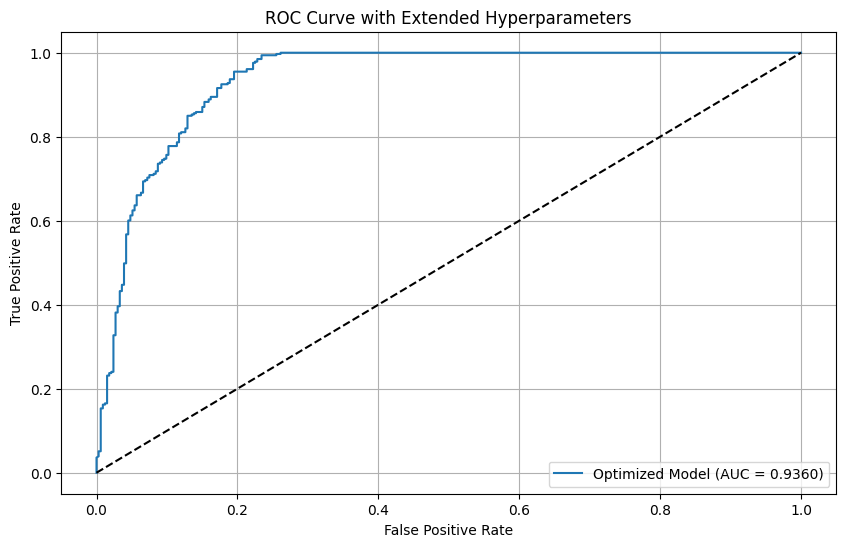

In [5]:
train_data = pd.read_csv('train_Mortgage.csv')
val_data = pd.read_csv('val_Mortgage.csv')

combined = pd.concat([train_data, val_data])
X = combined.drop('Mortgage', axis=1).values
y = combined['Mortgage'].values

X_train = X[:len(train_data)]
y_train = y[:len(train_data)]
X_val = X[len(train_data):]
y_val = y[len(train_data):]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

def create_model(trial, input_size):
    layers = []
    in_features = input_size

    n_layers = trial.suggest_int('n_layers', 1, 5)
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])

    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_{i}', 16, 512, step=16)
        layers.append(nn.Linear(in_features, out_features))

        if activation == 'ReLU':
            layers.append(nn.ReLU())
        elif activation == 'LeakyReLU':
            layers.append(nn.LeakyReLU(negative_slope=0.1))
        else:
            layers.append(nn.ELU())

        use_bn = trial.suggest_categorical(f'use_bn_{i}', [True, False])
        if use_bn:
            layers.append(nn.BatchNorm1d(out_features))

        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.7)
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        in_features = out_features

    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

def objective(trial):
    try:
        lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'NAdam', 'RAdam'])
        weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)

        model = create_model(trial, X_train.shape[1])

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'NAdam':
            optimizer = optim.NAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

        epochs = trial.suggest_int('epochs', 10, 30)
        scheduler_name = trial.suggest_categorical('scheduler', ['none', 'CosineAnnealing', 'ReduceLROnPlateau'])

        if scheduler_name == 'CosineAnnealing':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_name == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
        else:
            scheduler = None

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = nn.BCELoss()(outputs, labels)
                loss.backward()
                optimizer.step()

            if scheduler:
                if scheduler_name == 'ReduceLROnPlateau':
                    scheduler.step(loss)
                else:
                    scheduler.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor).numpy()
            roc_auc = roc_auc_score(y_val, y_pred)

        return roc_auc

    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        raise optuna.exceptions.TrialPruned()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

print("Best trial:")
trial = study.best_trial
print(f"  ROC AUC: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_params
final_model = create_model(study.best_trial, X_train.shape[1])

if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(final_model.parameters(),
                         lr=best_params['lr'],
                         weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'NAdam':
    optimizer = optim.NAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
else:
    optimizer = optim.RAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
for epoch in range(100):
    final_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = nn.BCELoss()(outputs, labels)
        loss.backward()
        optimizer.step()

final_model.eval()
with torch.no_grad():
    y_pred = final_model(X_val_tensor).numpy()
    roc_auc = roc_auc_score(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Optimized Model (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Extended Hyperparameters')
plt.legend()
plt.grid()
plt.show()
svm_for_mortgage = final_model

теперь составим модель для Pension

In [ ]:
import torch

[I 2025-04-22 16:29:23,940] A new study created in memory with name: no-name-9fa56263-57cd-4bae-964a-25ec62c89d9a
[I 2025-04-22 16:29:45,840] Trial 0 finished with value: 0.7804928633944607 and parameters: {'lr': 0.0013296826953422872, 'batch_size': 32, 'optimizer': 'AdamW', 'weight_decay': 0.023087717359098394, 'n_layers': 3, 'activation': 'ELU', 'n_units_0': 368, 'use_bn_0': False, 'dropout_0': 0.6043259726048461, 'n_units_1': 384, 'use_bn_1': False, 'dropout_1': 0.42563950201454415, 'n_units_2': 96, 'use_bn_2': False, 'dropout_2': 0.5456292027607217, 'epochs': 16, 'scheduler': 'none'}. Best is trial 0 with value: 0.7804928633944607.
[I 2025-04-22 16:30:08,459] Trial 1 finished with value: 0.7369224451532888 and parameters: {'lr': 1.704982943794599e-06, 'batch_size': 64, 'optimizer': 'AdamW', 'weight_decay': 0.018166117410454773, 'n_layers': 5, 'activation': 'LeakyReLU', 'n_units_0': 176, 'use_bn_0': False, 'dropout_0': 0.21972629468407212, 'n_units_1': 224, 'use_bn_1': False, 'dropo

Best trial:
  ROC AUC: 0.7805
  Params: 
    lr: 0.0013296826953422872
    batch_size: 32
    optimizer: AdamW
    weight_decay: 0.023087717359098394
    n_layers: 3
    activation: ELU
    n_units_0: 368
    use_bn_0: False
    dropout_0: 0.6043259726048461
    n_units_1: 384
    use_bn_1: False
    dropout_1: 0.42563950201454415
    n_units_2: 96
    use_bn_2: False
    dropout_2: 0.5456292027607217
    epochs: 16
    scheduler: none


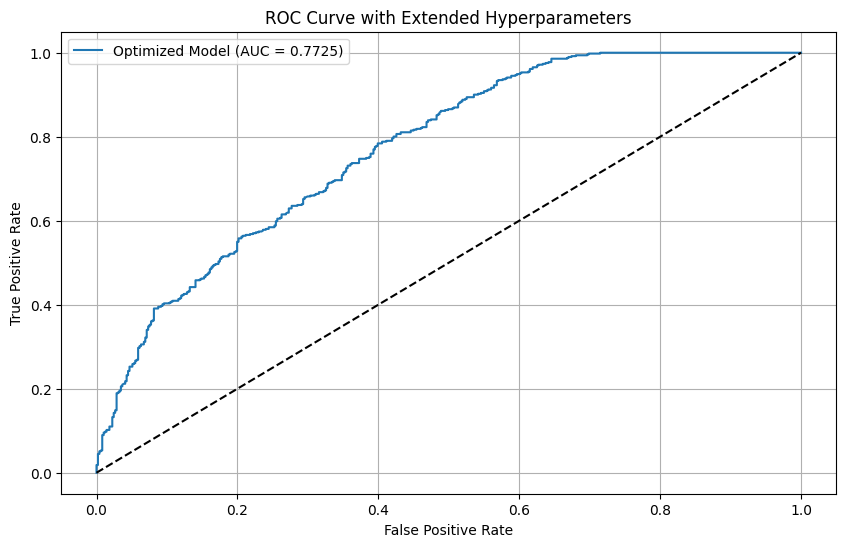

In [6]:
train_data = pd.read_csv('train_Pension.csv')
val_data = pd.read_csv('val_Pension.csv')

combined = pd.concat([train_data, val_data])
X = combined.drop('Pension', axis=1).values
y = combined['Pension'].values

X_train = X[:len(train_data)]
y_train = y[:len(train_data)]
X_val = X[len(train_data):]
y_val = y[len(train_data):]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

def create_model(trial, input_size):
    layers = []
    in_features = input_size

    n_layers = trial.suggest_int('n_layers', 1, 5)
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])

    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_{i}', 16, 512, step=16)
        layers.append(nn.Linear(in_features, out_features))

        if activation == 'ReLU':
            layers.append(nn.ReLU())
        elif activation == 'LeakyReLU':
            layers.append(nn.LeakyReLU(negative_slope=0.1))
        else:
            layers.append(nn.ELU())

        use_bn = trial.suggest_categorical(f'use_bn_{i}', [True, False])
        if use_bn:
            layers.append(nn.BatchNorm1d(out_features))

        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.7)
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        in_features = out_features

    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

def objective(trial):
    try:
        lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'NAdam', 'RAdam'])
        weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)

        model = create_model(trial, X_train.shape[1])

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'NAdam':
            optimizer = optim.NAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

        epochs = trial.suggest_int('epochs', 10, 30)
        scheduler_name = trial.suggest_categorical('scheduler', ['none', 'CosineAnnealing', 'ReduceLROnPlateau'])

        if scheduler_name == 'CosineAnnealing':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_name == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
        else:
            scheduler = None

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = nn.BCELoss()(outputs, labels)
                loss.backward()
                optimizer.step()

            if scheduler:
                if scheduler_name == 'ReduceLROnPlateau':
                    scheduler.step(loss)
                else:
                    scheduler.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor).numpy()
            roc_auc = roc_auc_score(y_val, y_pred)

        return roc_auc

    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        raise optuna.exceptions.TrialPruned()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

print("Best trial:")
trial = study.best_trial
print(f"  ROC AUC: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_params
final_model = create_model(study.best_trial, X_train.shape[1])

if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(final_model.parameters(),
                         lr=best_params['lr'],
                         weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'NAdam':
    optimizer = optim.NAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
else:
    optimizer = optim.RAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
for epoch in range(100):
    final_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = nn.BCELoss()(outputs, labels)
        loss.backward()
        optimizer.step()

final_model.eval()
with torch.no_grad():
    y_pred = final_model(X_val_tensor).numpy()
    roc_auc = roc_auc_score(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Optimized Model (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Extended Hyperparameters')
plt.legend()
plt.grid()
plt.show()
svm_for_Pension = final_model

теперь повторим для savings

[I 2025-04-22 17:10:05,933] A new study created in memory with name: no-name-eaa92631-ab01-4a40-86e9-8b9776c086a6
[I 2025-04-22 17:10:14,092] Trial 0 finished with value: 0.6783733062567838 and parameters: {'lr': 9.727098570904123e-05, 'batch_size': 128, 'optimizer': 'AdamW', 'weight_decay': 0.07760611148805896, 'n_layers': 4, 'activation': 'LeakyReLU', 'n_units_0': 16, 'use_bn_0': True, 'dropout_0': 0.2222782597767108, 'n_units_1': 464, 'use_bn_1': False, 'dropout_1': 0.38096541615620627, 'n_units_2': 208, 'use_bn_2': True, 'dropout_2': 0.4936577693475594, 'n_units_3': 336, 'use_bn_3': True, 'dropout_3': 0.1259499170785118, 'epochs': 11, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 0 with value: 0.6783733062567838.
[I 2025-04-22 17:10:56,553] Trial 1 finished with value: 0.6967382094464478 and parameters: {'lr': 3.6833486159928245e-06, 'batch_size': 32, 'optimizer': 'NAdam', 'weight_decay': 0.05148768772377619, 'n_layers': 3, 'activation': 'ELU', 'n_units_0': 432, 'use_bn_0': True

Best trial:
  ROC AUC: 0.6988
  Params: 
    lr: 4.857055225150195e-05
    batch_size: 256
    optimizer: AdamW
    weight_decay: 0.07783200770789479
    n_layers: 4
    activation: ELU
    n_units_0: 176
    use_bn_0: False
    dropout_0: 0.23212942249392776
    n_units_1: 352
    use_bn_1: False
    dropout_1: 0.5444968697220387
    n_units_2: 80
    use_bn_2: False
    dropout_2: 0.6039734255630672
    n_units_3: 96
    use_bn_3: False
    dropout_3: 0.4522123791420057
    epochs: 12
    scheduler: CosineAnnealing


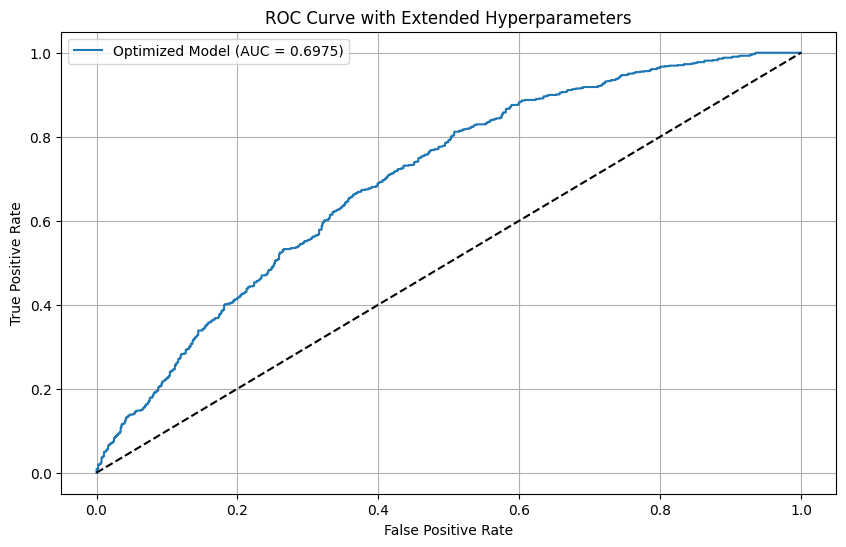

In [7]:
train_data = pd.read_csv('train_Savings.csv')
val_data = pd.read_csv('val_Savings.csv')

combined = pd.concat([train_data, val_data])
X = combined.drop('Savings', axis=1).values
y = combined['Savings'].values

X_train = X[:len(train_data)]
y_train = y[:len(train_data)]
X_val = X[len(train_data):]
y_val = y[len(train_data):]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

def create_model(trial, input_size):
    layers = []
    in_features = input_size

    n_layers = trial.suggest_int('n_layers', 1, 5)
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])

    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_{i}', 16, 512, step=16)
        layers.append(nn.Linear(in_features, out_features))

        if activation == 'ReLU':
            layers.append(nn.ReLU())
        elif activation == 'LeakyReLU':
            layers.append(nn.LeakyReLU(negative_slope=0.1))
        else:
            layers.append(nn.ELU())

        use_bn = trial.suggest_categorical(f'use_bn_{i}', [True, False])
        if use_bn:
            layers.append(nn.BatchNorm1d(out_features))

        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.7)
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        in_features = out_features

    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

def objective(trial):
    try:
        lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'NAdam', 'RAdam'])
        weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)

        model = create_model(trial, X_train.shape[1])

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'NAdam':
            optimizer = optim.NAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

        epochs = trial.suggest_int('epochs', 10, 30)
        scheduler_name = trial.suggest_categorical('scheduler', ['none', 'CosineAnnealing', 'ReduceLROnPlateau'])

        if scheduler_name == 'CosineAnnealing':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_name == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
        else:
            scheduler = None

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = nn.BCELoss()(outputs, labels)
                loss.backward()
                optimizer.step()

            if scheduler:
                if scheduler_name == 'ReduceLROnPlateau':
                    scheduler.step(loss)
                else:
                    scheduler.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor).numpy()
            roc_auc = roc_auc_score(y_val, y_pred)

        return roc_auc

    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        raise optuna.exceptions.TrialPruned()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

print("Best trial:")
trial = study.best_trial
print(f"  ROC AUC: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_params
final_model = create_model(study.best_trial, X_train.shape[1])

if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(final_model.parameters(),
                         lr=best_params['lr'],
                         weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'NAdam':
    optimizer = optim.NAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
else:
    optimizer = optim.RAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
for epoch in range(100):
    final_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = nn.BCELoss()(outputs, labels)
        loss.backward()
        optimizer.step()

final_model.eval()
with torch.no_grad():
    y_pred = final_model(X_val_tensor).numpy()
    roc_auc = roc_auc_score(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Optimized Model (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Extended Hyperparameters')
plt.legend()
plt.grid()
plt.show()
svm_for_Savings = final_model

резульаты полученных моделей несколько выше чем у других типов, но время обучения сильно больше

In [13]:
svm_for_Mortgage = svm_for_mortgage

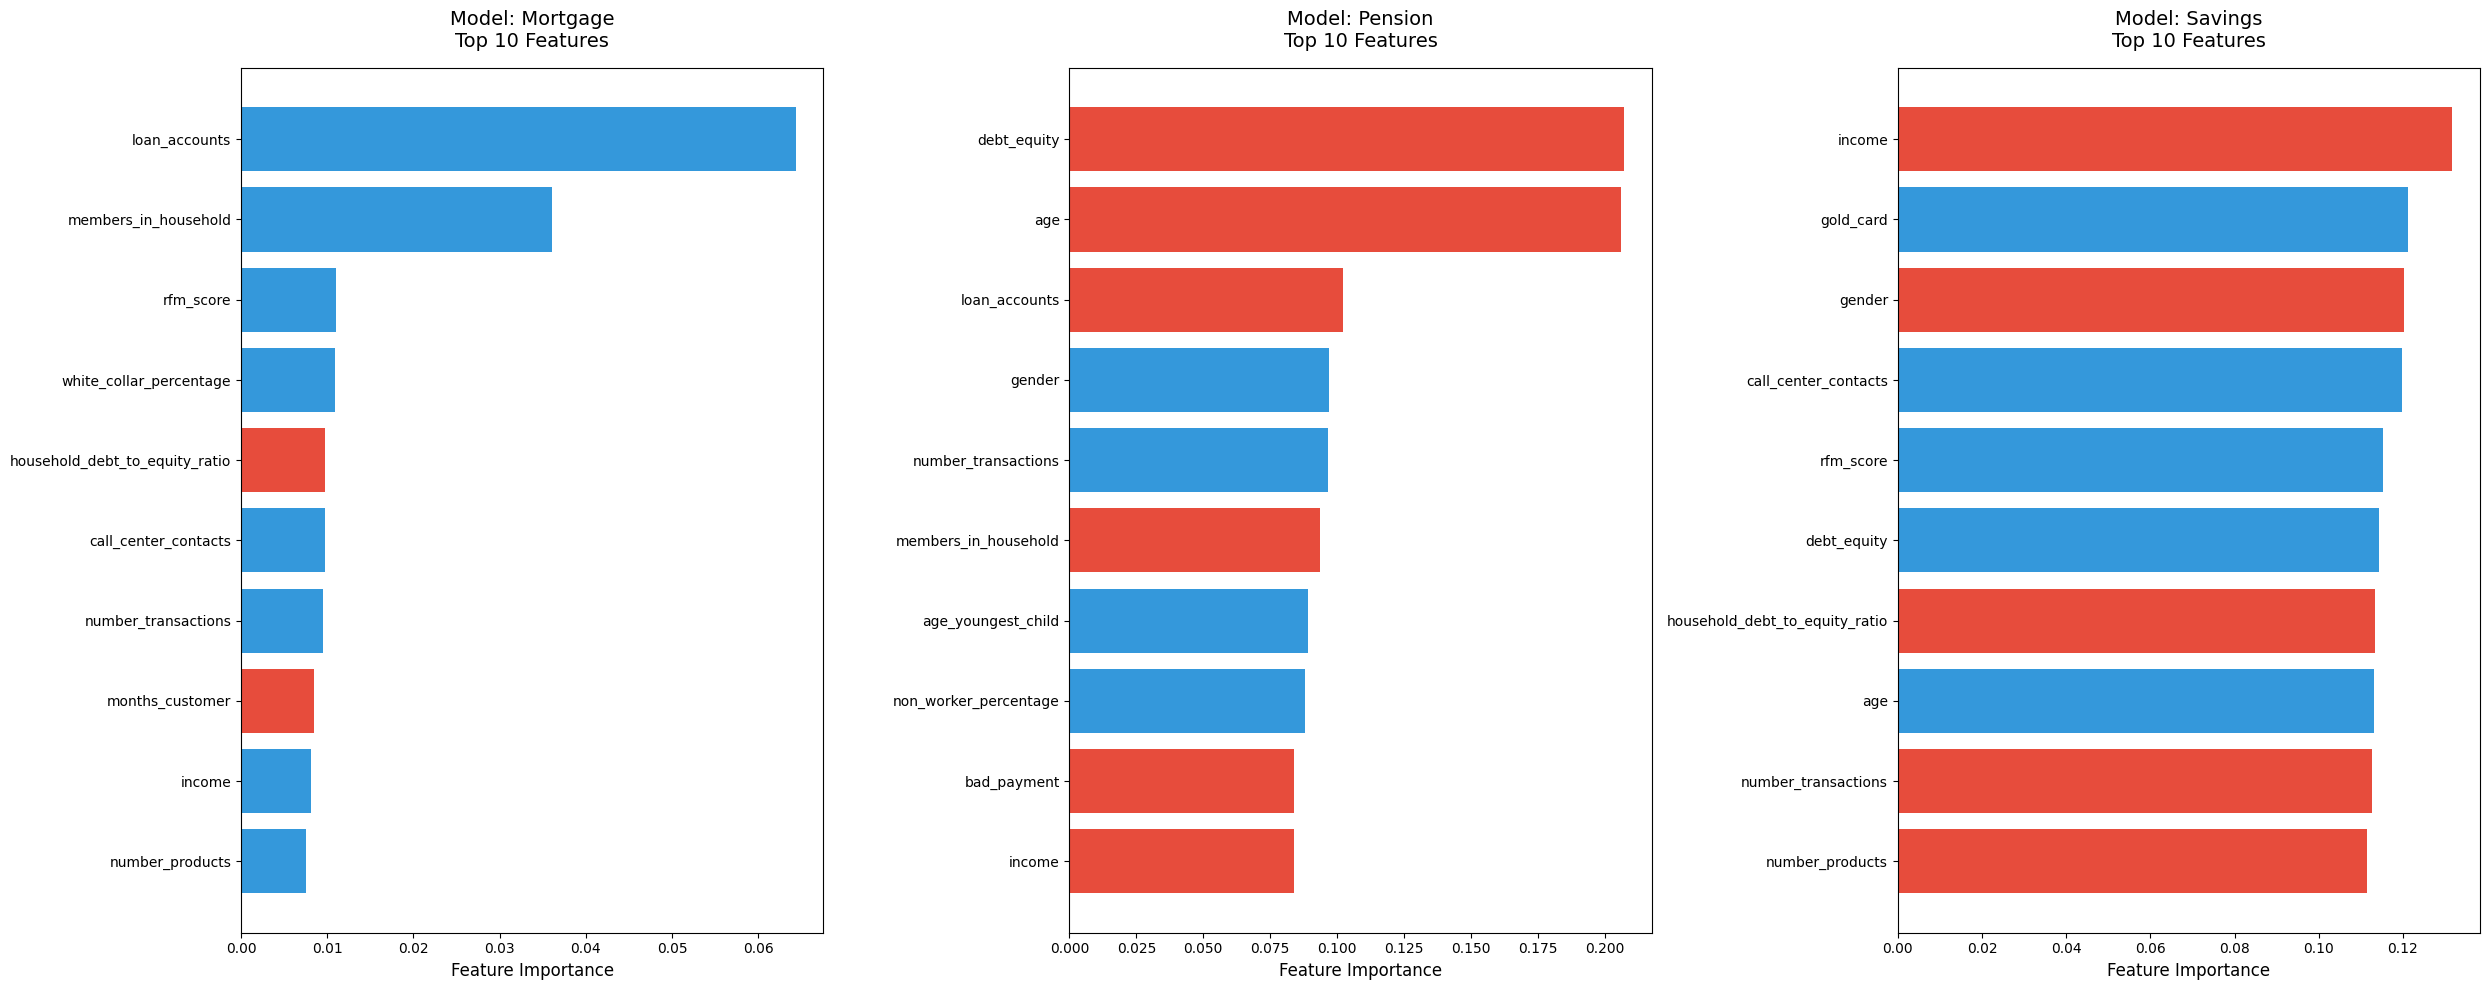

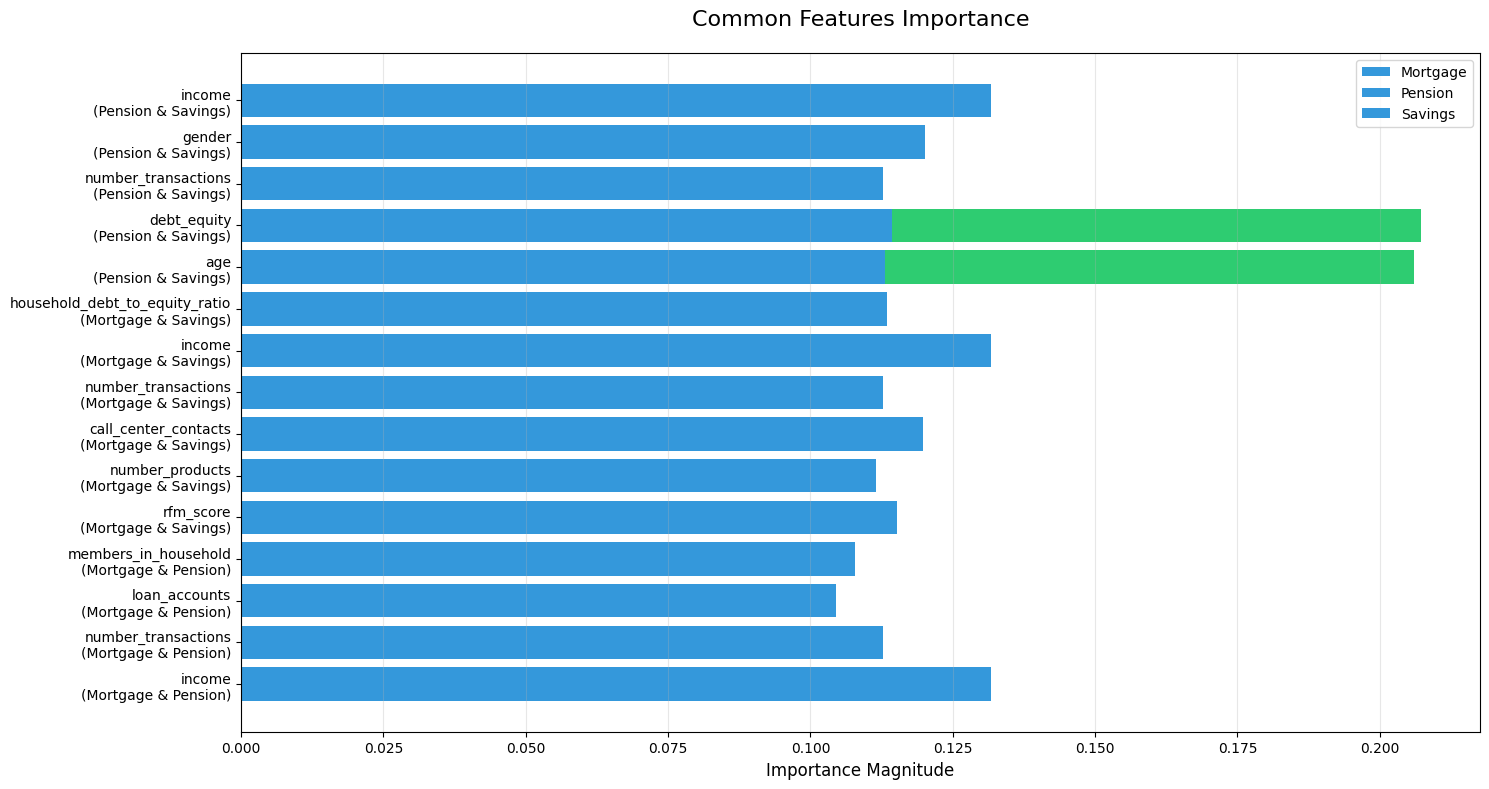


Stability Analysis Table:
                  Feature   Mortgage    Pension    Savings
                      age Not in top   0.21 (-)   0.11 (+)
       age_youngest_child Not in top   0.09 (+) Not in top
              bad_payment Not in top   0.08 (-) Not in top
     call_center_contacts   0.01 (+) Not in top   0.12 (+)
              debt_equity Not in top   0.21 (-)   0.11 (+)
                   gender Not in top   0.10 (+)   0.12 (-)
                gold_card Not in top Not in top   0.12 (+)
household_debt_to_equi...   0.01 (-) Not in top   0.11 (-)
                   income   0.01 (+)   0.08 (-)   0.13 (-)
            loan_accounts   0.06 (+)   0.10 (-) Not in top
     members_in_household   0.04 (+)   0.09 (-) Not in top
          months_customer   0.01 (-) Not in top Not in top
    non_worker_percentage Not in top   0.09 (+) Not in top
          number_products   0.01 (+) Not in top   0.11 (-)
      number_transactions   0.01 (+)   0.10 (+)   0.11 (-)
                rfm_score   0

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations
import torch

def get_feature_importances(model):
    for layer in model.children():
        if isinstance(layer, torch.nn.Linear):
            weights = layer.weight.data.numpy()
            return np.mean(np.abs(weights), axis=0), np.sign(np.mean(weights, axis=0))
    raise ValueError("Linear layer not found in model")

def plot_analysis(models_dict, products):
    """Полный анализ моделей для трех продуктов"""
    feature_data = {}

    for product in products:
        train_data = pd.read_csv(f'train_{product}.csv')
        features = train_data.drop(product, axis=1).columns.values
        model = models_dict[product]

        magnitudes, signs = get_feature_importances(model)

        feature_data[product] = {
            'features': features,
            'magnitudes': magnitudes,
            'signs': signs
        }

    fig, axes = plt.subplots(1, 3, figsize=(25, 10))

    for idx, (product, ax) in enumerate(zip(products, axes)):
        data = feature_data[product]
        sorted_idx = np.argsort(data['magnitudes'])[::-1][:10]

        features = data['features'][sorted_idx]
        values = data['magnitudes'][sorted_idx]
        signs = data['signs'][sorted_idx]

        colors = ['#e74c3c' if s < 0 else '#3498db' for s in signs]
        ax.barh(features, values, color=colors, height=0.8)
        ax.invert_yaxis()
        ax.set_title(f"Model: {product}\nTop 10 Features", fontsize=14, pad=15)
        ax.set_xlabel('Feature Importance', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    plt.show()

    top_features = {product: set(feature_data[product]['features'][
        np.argsort(feature_data[product]['magnitudes'])[::-1][:10]])
                   for product in products}

    common_features = {}
    for prod_pair in combinations(products, 2):
        common = top_features[prod_pair[0]].intersection(top_features[prod_pair[1]])
        if common:
            common_features[f"{prod_pair[0]} & {prod_pair[1]}"] = common

    if common_features:
        plt.figure(figsize=(15, 8))
        for i, (pair, features) in enumerate(common_features.items()):
            for feat in features:
                impacts = []
                for prod in products:
                    idx = np.where(feature_data[prod]['features'] == feat)[0][0]
                    impacts.append(feature_data[prod]['magnitudes'][idx])

                plt.barh(f"{feat}\n({pair})", impacts, color=['#3498db', '#2ecc71'])

        plt.title("Common Features Importance", fontsize=16, pad=20)
        plt.xlabel("Importance Magnitude", fontsize=12)
        plt.legend(products)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

    stability_data = []
    all_features = set().union(*[top_features[p] for p in products])

    for feat in all_features:
        row = {'Feature': feat}
        for product in products:
            if feat in top_features[product]:
                idx = np.where(feature_data[product]['features'] == feat)[0][0]
                row[product] = f"{feature_data[product]['magnitudes'][idx]:.2f} ({'+' if feature_data[product]['signs'][idx] > 0 else '-'})"
            else:
                row[product] = "Not in top"
        stability_data.append(row)

    df = pd.DataFrame(stability_data).sort_values(by='Feature')
    print("\nStability Analysis Table:")
    print(df.to_string(index=False, max_colwidth=25))

if __name__ == "__main__":
    models = {
        'Mortgage': svm_for_Mortgage,
        'Pension': svm_for_Pension,
        'Savings': svm_for_Savings
    }
    plot_analysis(models, products=['Mortgage', 'Pension', 'Savings'])